<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Avanzados en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Introduction to Deep Neural Networks</div><br>
    <div style="font-size: large">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, load_sample_images, load_digits
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, LSTM, LeakyReLU
from tensorflow.keras.models import Model, Sequential

from scipy.ndimage import filters

import logging
import warnings
from sklearn.exceptions import ConvergenceWarning

matplotlib.rc("figure", figsize=(15, 5))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
seed = 123

# Autoencoder

## Dataset

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
print("Number of axis:   ", x_train.ndim)
print("Dimension (train):", x_train.shape)
print("Dimension (test): ", x_test.shape)
print("Data type:        ", x_train.dtype)

Number of axis:    3
Dimension (train): (60000, 28, 28)
Dimension (test):  (10000, 28, 28)
Data type:         uint8


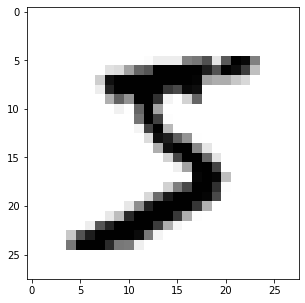

In [6]:
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

In [10]:
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train_1D = x_train.reshape(len(x_train), -1)
x_test_1D = x_test.reshape(len(x_test), -1)

## Autoencoder Builder

In [8]:
def autoencoder_builder(inp_lay, enc_lay, dec_lay, optimizer="adam", encoding_dim=32, n_dec_lay=1):
    # AE.
    autoencoder = Model(inp_lay, dec_lay)
    autoencoder.compile(optimizer=optimizer, loss="mse", metrics=["mse"])

    # Encoder.
    encoder = Model(inp_lay, enc_lay)

    # Decoder.
    enc_inp_lay = Input(shape=(encoding_dim,))
    decoder = enc_inp_lay
    for l in range(n_dec_lay, 0, -1):
        decoder = autoencoder.layers[-l](decoder)
    decoder = Model(enc_inp_lay, decoder)

    return [autoencoder, encoder, decoder]

## Simple Autoencoders

In [9]:
encoding_dim = 16

inp_lay = Input(shape=(x_train_1D.shape[1],))
enc_lay = Dense(encoding_dim, activation="relu")(inp_lay)
dec_lay = Dense(x_train_1D.shape[1], activation="sigmoid")(enc_lay)

[autoencoder, encoder, decoder] = autoencoder_builder(inp_lay,
                                                      enc_lay,
                                                      dec_lay,
                                                      encoding_dim=encoding_dim)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               13328     
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________


### Training

In [10]:
hisory = autoencoder.fit(x_train_1D, x_train_1D, epochs=10, batch_size=256, shuffle=True)

Epoch 1/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0821 - mse: 0.0821
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0444 - mse: 0.0444
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0351 - mse: 0.0351
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0304
Epoch 5/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0277 - mse: 0.0277
Epoch 6/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0264 - mse: 0.0264
Epoch 7/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0255 - mse: 0.0255
Epoch 8/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0248 - mse: 0.0248
Epoch 9/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0243 - mse: 0.0243
Epoch 10/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0238 - mse: 0.0238A: 3


### Prediction

In [11]:
encoded_imgs = encoder.predict(x_test_1D)
decoded_imgs = decoder.predict(encoded_imgs)
print("Prediction error: %.3f" % autoencoder.evaluate(x_test_1D, x_test_1D, verbose=0)[1])

Prediction error: 0.023


### Reconstruction

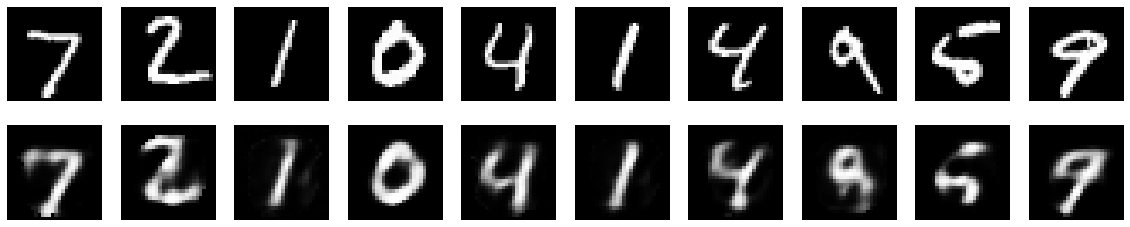

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")

plt.show()

### Embedding

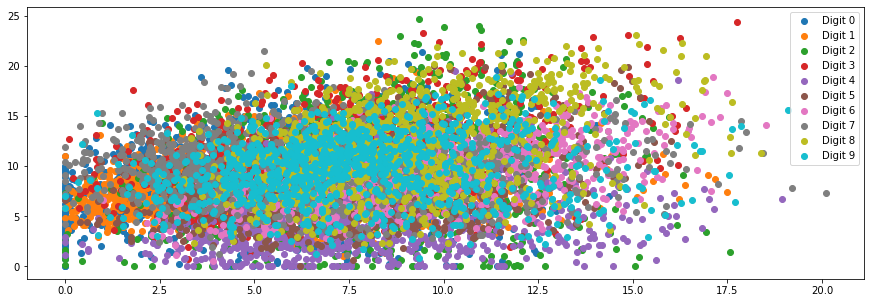

In [13]:
for i in range(10):
    plt.scatter(encoded_imgs[y_test==i, 0], encoded_imgs[y_test==i, 1], label="Digit %d" % i)

plt.legend()
plt.show()

## Sparse Autoencoders

In [14]:
encoding_dim = 800

inp_lay = Input(shape=(x_train_1D.shape[1],))
enc_lay = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(1e-3))(inp_lay)
dec_lay = Dense(x_train_1D.shape[1], activation="sigmoid")(enc_lay)

In [15]:
[autoencoder, encoder, decoder] = autoencoder_builder(inp_lay,
                                                      enc_lay,
                                                      dec_lay,
                                                      encoding_dim=encoding_dim)
autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               627984    
Total params: 1,255,984
Trainable params: 1,255,984
Non-trainable params: 0
_________________________________________________________________


### Training

In [16]:
hisory = autoencoder.fit(x_train_1D, x_train_1D, epochs=10, batch_size=256, shuffle=True)

Epoch 1/10
235/235 [==============================] - 5s 19ms/step - loss: 0.1039 - mse: 0.0787
Epoch 2/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0524 - mse: 0.0384
Epoch 3/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0450 - mse: 0.0325
Epoch 4/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0407 - mse: 0.0290
Epoch 5/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0377 - mse: 0.0264
Epoch 6/10
235/235 [==============================] - 6s 24ms/step - loss: 0.0355 - mse: 0.0245
Epoch 7/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0338 - mse: 0.0231
Epoch 8/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0325 - mse: 0.0220
Epoch 9/10
235/235 [==============================] - 6s 24ms/step - loss: 0.0313 - mse: 0.0211
Epoch 10/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0304 - mse: 0.0204


### Prediction

In [17]:
encoded_imgs = encoder.predict(x_test_1D)
decoded_imgs = decoder.predict(encoded_imgs)
print("Prediction error: %.3f" % autoencoder.evaluate(x_test_1D, x_test_1D, verbose=0)[1])

Prediction error: 0.020


### Reconstruction

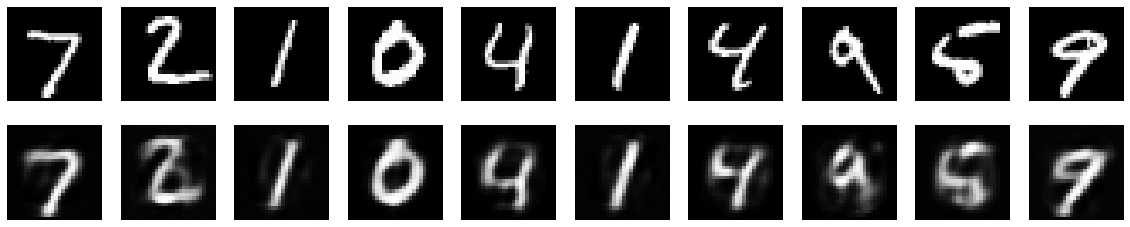

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")

plt.show()

### Embedding

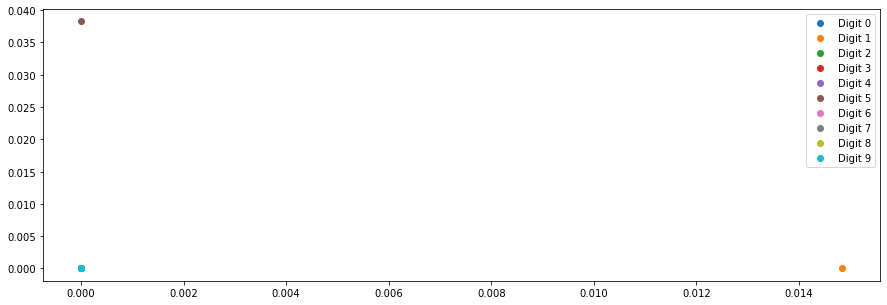

In [19]:
for i in range(10):
    plt.scatter(encoded_imgs[y_test==i, 0], encoded_imgs[y_test==i, 1], label="Digit %d" % i)

plt.legend()
plt.show()

In [20]:
print("Sparsity: %.2f%%" % (100 * (encoded_imgs == 0).mean()))

Sparsity: 97.71%


## Deep Autoencoders

In [21]:
inp_lay = Input(shape=(784,))
enc_lay = Dense(128, activation="relu")(inp_lay)
enc_lay = Dense(64, activation="relu")(enc_lay)
enc_lay = Dense(2, activation="relu")(enc_lay)
dec_lay = Dense(64, activation="relu")(enc_lay)
dec_lay = Dense(128, activation="relu")(dec_lay)
dec_lay = Dense(784, activation="sigmoid")(dec_lay)

In [22]:
[autoencoder, encoder, decoder] = autoencoder_builder(inp_lay,
                                                      enc_lay,
                                                      dec_lay,
                                                      encoding_dim=2,
                                                      n_dec_lay=3)
autoencoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 784)             

### Training

In [23]:
hisory = autoencoder.fit(x_train_1D, x_train_1D, epochs=10, batch_size=256, shuffle=True)

Epoch 1/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0759 - mse: 0.0759
Epoch 2/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0558 - mse: 0.0558
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0521 - mse: 0.0521
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0502 - mse: 0.0502
Epoch 5/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0483 - mse: 0.0483
Epoch 6/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0467 - mse: 0.0467
Epoch 7/10
235/235 [==============================] - 4s 17ms/step - loss: 0.0456 - mse: 0.0456
Epoch 8/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0447 - mse: 0.0447
Epoch 9/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0441 - mse: 0.0441
Epoch 10/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0436 - mse: 0.0436


### Predicción

In [24]:
encoded_imgs = encoder.predict(x_test_1D)
decoded_imgs = decoder.predict(encoded_imgs)
print("Prediction error: %.3f" % autoencoder.evaluate(x_test_1D, x_test_1D, verbose=0)[1])

Prediction error: 0.043


### Reconstruction

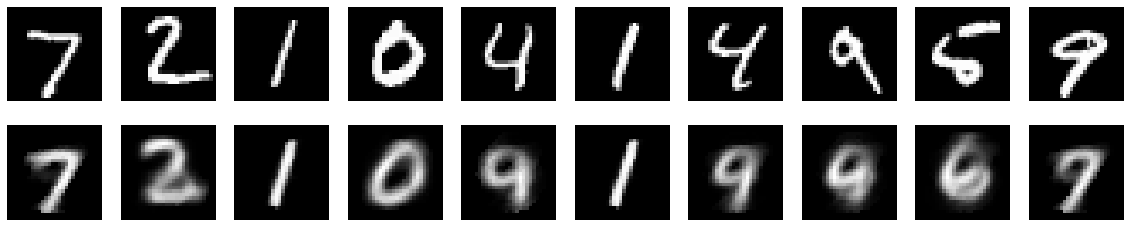

In [25]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis("off")

plt.show()

### Embedding

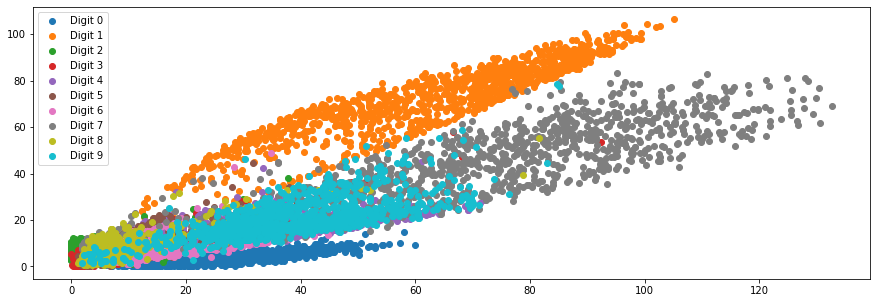

In [26]:
for i in range(10):
    plt.scatter(encoded_imgs[y_test==i, 0], encoded_imgs[y_test==i, 1],label="Digit %d" % i)

plt.legend()
plt.show()

# Convolutional Neural Networks

## Convolution of Images

### Original Image

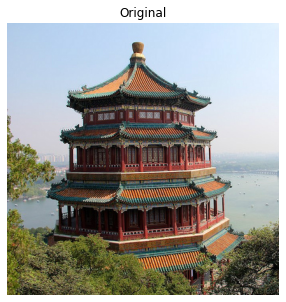

In [27]:
china = load_sample_images().images[0]
china = china[:china.shape[0], :china.shape[0], :]
plt.imshow(china)
plt.title("Original")
plt.axis("off")
plt.show()

### Convolution with Different Filters

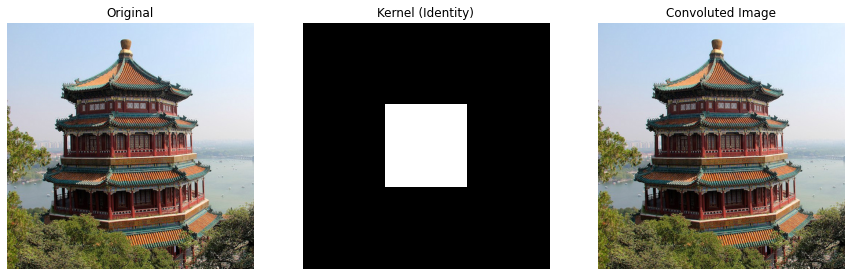

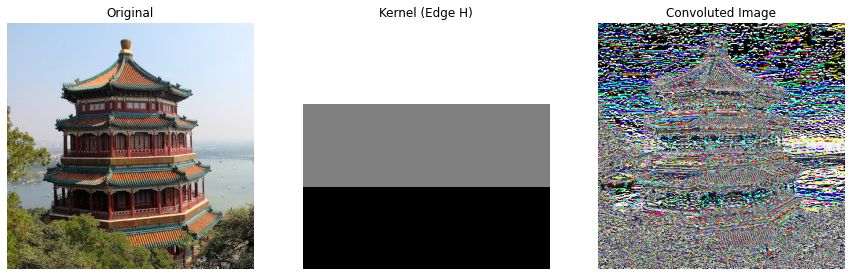

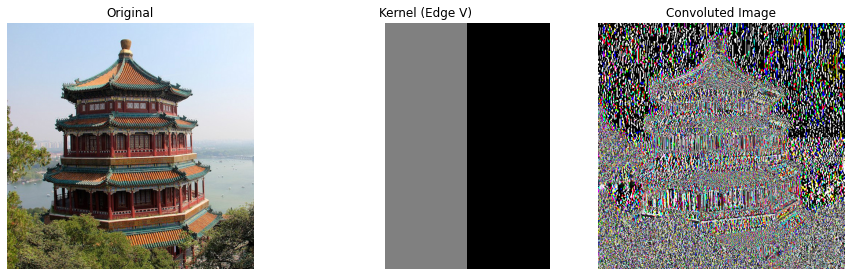

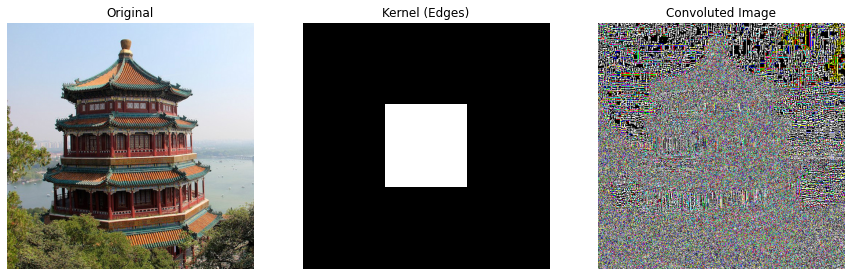

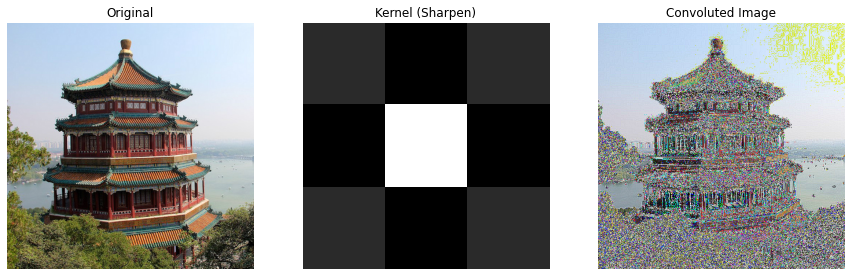

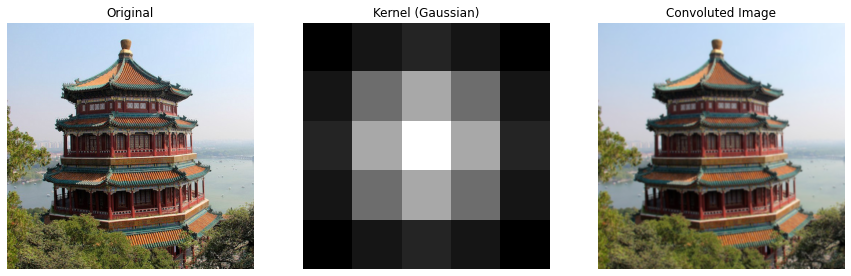

In [28]:
kv = []
kv.append(np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]]))
kv.append(np.array([[1, 1, 1],
                    [0, 0, 0],
                    [-1, -1, -1]]))
kv.append(kv[-1].T)
kv.append(np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]]))
kv.append(np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]]))
kv.append(1 / 256 * np.array([[1, 4, 6, 4, 1],
                              [4, 16, 24, 16, 4],
                              [6, 24, 36, 24, 6],
                              [4, 16, 24, 16, 4],
                              [1, 4, 6, 4, 1]]))

lv = ("Identity", "Edge H", "Edge V", "Edges", "Sharpen", "Gaussian")

for k, l in zip(kv, lv):
    k = k.reshape(k.shape[0], k.shape[1], 1)

    plt.subplot(1, 3, 1)
    plt.imshow(china)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(k)
    plt.title("Kernel (%s)" % l)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(filters.convolve(china, k))
    plt.title("Convoluted Image")
    plt.axis("off")

    plt.show()

## Dataset

In [29]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

## Convolutional Neural Network

In [30]:
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3,3),  activation="relu", input_shape=(28,28,1)))
cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.4))
cnn.add(Dense(10, activation="softmax"))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [31]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### Training

In [32]:
history = cnn.fit(x_train, y_train, validation_split=0.75, batch_size=256, epochs=5)

Epoch 1/5
59/59 [==============================] - 30s 508ms/step - loss: 0.6401 - accuracy: 0.8061 - val_loss: 0.2068 - val_accuracy: 0.9386
Epoch 2/5
59/59 [==============================] - 31s 520ms/step - loss: 0.1893 - accuracy: 0.9457 - val_loss: 0.1137 - val_accuracy: 0.9661
Epoch 3/5
59/59 [==============================] - 38s 648ms/step - loss: 0.1136 - accuracy: 0.9654 - val_loss: 0.0801 - val_accuracy: 0.9765
Epoch 4/5
59/59 [==============================] - 33s 557ms/step - loss: 0.0799 - accuracy: 0.9759 - val_loss: 0.0672 - val_accuracy: 0.9798
Epoch 5/5
59/59 [==============================] - 35s 591ms/step - loss: 0.0650 - accuracy: 0.9796 - val_loss: 0.0623 - val_accuracy: 0.9814


### Evaluation

In [33]:
print("Test accuracy: %.3f%%" % (100 * cnn.evaluate(x_test, y_test, verbose=0)[1]))

Test accuracy: 98.260%


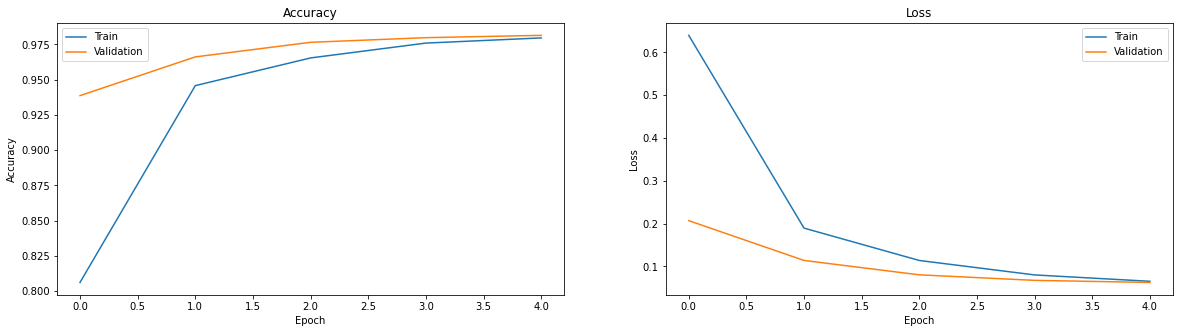

In [34]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])

plt.show()

### Prediction

In [35]:
preds = cnn.predict(x_test)
y_test_t = np.argmax(y_test, axis=1)
y_test_p = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test_t, y_test_p)

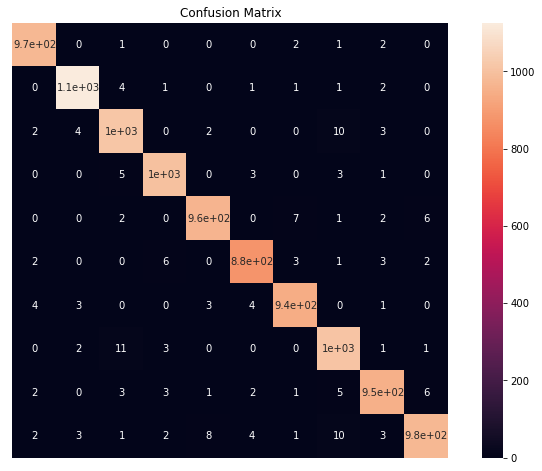

In [38]:
import seaborn as sn

plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.axis("equal")
plt.axis("off")

plt.show()

# Recurrent Neural Networks

## Dataset

(1999, 1, 1)
(1999, 1, 1)


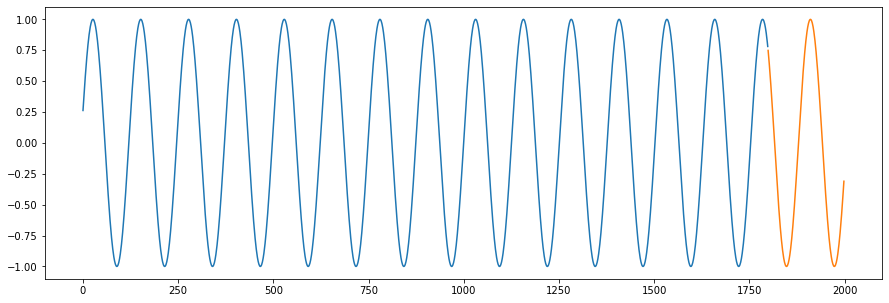

In [39]:
x = np.sin(np.linspace(-50, 50, 2000))

X = x[:-1].reshape(- 1, 1, 1)
y = x[1:].reshape(- 1, 1, 1)

print(X.shape)
print(y.shape)

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=False)
plt.plot(range(len(x_tr.ravel())), x_tr.ravel())
plt.plot(range(len(x_tr.ravel()), len(x_tr.ravel()) + len(x_te.ravel())), x_te.ravel())
plt.show()

## Recurrent Neural Network

In [40]:
rnn = Sequential()
rnn.add(LSTM(50, activation="relu", input_shape=(1, 1), return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(50, activation="relu", input_shape=(1, 1), return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(Dense(1))

rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1, 1)              51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [41]:
rnn.compile(loss="mean_squared_error", optimizer="adam")

### Training

In [42]:
history = rnn.fit(x_tr, y_tr, epochs=20, batch_size=128)

Epoch 1/20
15/15 [==============================] - 0s 6ms/step - loss: 0.4913
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 0.4627
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 0.4139
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 0.3355
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 0.2215
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0950
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 8/20
15/15 [==============================] - 0s 4ms/step - loss: 0.0191
Epoch 9/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 10/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 11/20
15/15 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 12/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 13/20
15/15 [==============================

### Prediction

#### Fixed Horizon

In [43]:
preds = rnn.predict(x_te)

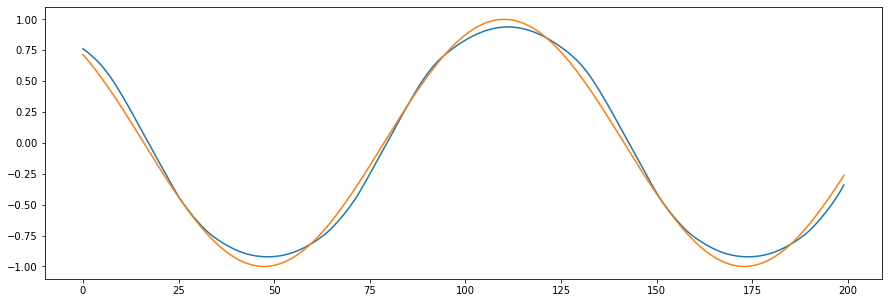

In [44]:
plt.plot(preds.ravel())
plt.plot(y_te.ravel())
plt.show()

#### Temporal Series

In [45]:
preds = np.zeros(len(x_te))

prev = np.copy(y_tr.ravel())
for i in range(len(x_te)):
    print("Predicting step %4d / %4d" % (i + 1, len(x_te)), end="\r")
    preds[i] = rnn.predict(prev.reshape(-1, 1, 1))[-1]
    prev = np.concatenate((prev, np.array(preds[i]).reshape(1)))

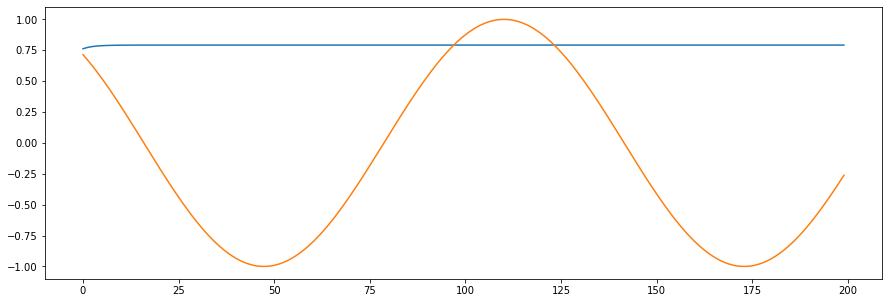

In [46]:
plt.plot(preds)
plt.plot(y_te.ravel())
plt.show()

# Generative Adversarial Network

## Generator

In [4]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=784, activation="sigmoid"))

    generator.compile(loss="binary_crossentropy", optimizer="adam")
    return generator

generator = create_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

## Discriminator

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation="sigmoid"))
    
    discriminator.compile(loss="binary_crossentropy", optimizer="adam")
    return discriminator

discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

## GAN

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    gan = Model(inputs=gan_input, outputs=discriminator(generator(gan_input)))
    gan.compile(loss="binary_crossentropy", optimizer="adam")
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


## Training

In [7]:
def plot_generated_images(generator, dim=(5, 5), figsize=(5, 5)):
    examples = np.prod(dim)
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

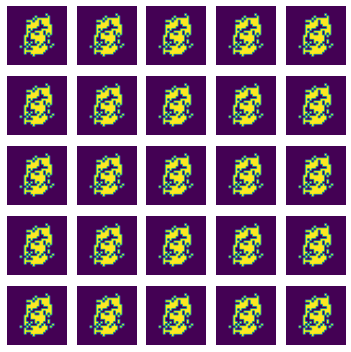

In [13]:
max_iter = 1
batch_size = 128
batch_count = int(x_train_1D.shape[0] / batch_size)

for i in range(max_iter):
    print("Iteration: %d" % i, end="\r")

    noise = np.random.normal(0, 1, [batch_size, 100])

    generated_images = generator.predict(noise)
    real_images = x_train_1D[np.random.randint(low=0, high=x_train_1D.shape[0], size=batch_size)]

    X = np.concatenate([real_images, generated_images])

    y_dis = np.zeros(2 * batch_size)
    y_dis[:batch_size] = 0.9

    discriminator.trainable=True
    discriminator.train_on_batch(X, y_dis)

    noise = np.random.normal(0, 1, [batch_size, 100])
    y_gen = np.ones(batch_size)

    discriminator.trainable=False
    gan.train_on_batch(noise, y_gen)

    if (i % 20) == 0:
        plot_generated_images(generator)